In [3]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math

In [125]:
!pwd

/Users/wisdomikezogwo/Documents/CSResearch/MRIseg/src/dataset


In [803]:
modalities = ['flair', 'seg', 't1', 't1ce', 't2']
mode = modalities[0]
ex_img = nib.load(f'../../MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_{mode}.nii.gz')
ex_seg = nib.load(f'../../MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_{modalities[1]}.nii.gz')


In [804]:
ex_img = np.array(ex_img.get_fdata())
ex_seg = np.array(ex_seg.get_fdata())

In [1054]:
ex_img.shape

(240, 240, 155)

In [754]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")


In [755]:

slice_0 = ex_img[120, :, :]
slice_1 = ex_img[:, 120, :]
slice_2 = ex_img[:, :, 77]


Text(0.5, 0.98, 'Center slices for seg image')

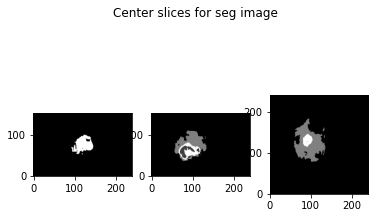

In [756]:
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f"Center slices for {mode} image") 

In [759]:
np.unique(slice_2)

array([0., 1., 2., 4.])

In [761]:
np.unique(p_seg_image)

array([0., 1., 2., 3.], dtype=float32)

In [789]:
import util

In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils

import os
import nibabel as nib
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import random
import skimage.transform as skTrans
import cv2
from numpy import logical_and as l_and, logical_not as l_not
from scipy.spatial.distance import directed_hausdorff


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

In [3]:
image_dir = '../../MICCAI_BraTS2020_TrainingData/'

In [11]:
naming = pd.read_csv(f'../../MICCAI_BraTS2020_TrainingData/name_mapping.csv') # , index_col=0)
data_df = pd.DataFrame(naming['BraTS_2020_subject_ID'])

In [944]:
n_p = 50 # n_patients_to_train_with
train_df = data_df[:n_p]
valid_df = data_df[n_p:n_p*2]

# Transfomations

In [4]:
class ScaleToFixed(object):

    def __init__(self, new_shape, interpolation=1, channels=4):
        self.shape= new_shape
        self.interpolation = interpolation
        self.channels = channels

    def __call__(self, image):
        # print('first shape', image.shape)
        if image is not None: # (some patients don't have segmentations)
            if self.channels == 1:
                short_shape = (self.shape[1], self.shape[2], self.shape[3])
                image = skTrans.resize(image, short_shape, order=self.interpolation, preserve_range=True)  #
                image = image.reshape(self.shape)
            else:
                image = skTrans.resize(image, self.shape, order=self.interpolation, preserve_range=True)  #

        # print('second shape', image.shape)
        # print()
        return image

class RandomFlip(object):
    """Randomly flips (horizontally as well as vertically) the given PIL.Image with a probability of 0.5
    """
    def __init__(self, prob_flip=0.5):
        self.prob_flip= prob_flip
    def __call__(self, image):

        if random.random() < self.prob_flip:
            flip_type = np.random.randint(0, 3) # flip across any 3D axis
            image = np.flip(image, flip_type)
        return image

class ZeroChannel(object):
    """Randomly sets channel to zero the given PIL.Image with a probability of 0.25
    """
    def __init__(self, prob_zero=0.25, channels=4):
        self.prob_zero= prob_zero
        self.channels = channels
    def __call__(self, image):

        if np.random.random() < self.prob_zero:
            channel_to_zero = np.random.randint(0, self.channels) # flip across any 3D axis
            zeros = np.zeros((image.shape[1], image.shape[2], image.shape[3]))
            image[channel_to_zero, :, :, :] = zeros
        return image

class ZeroSprinkle(object):
    def __init__(self, prob_zero=0.25, prob_true=0.5, channels=4):
        self.prob_zero=prob_zero
        self.prob_true=prob_true
        self.channels=channels
    def __call__(self, image):

        if self.prob_true:
            mask = np.random.rand(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            mask[mask < self.prob_zero] = 0
            mask[mask > 0] = 1
            image = image*mask

        return image


class MinMaxNormalize(object):
    """Min-Max normalization
    """
    def __call__(self, image):
        def norm(im):
            im = im.astype(np.float32)
            min_v = np.min(im)
            max_v = np.max(im)
            im = (im - min_v)/(max_v - min_v)
            return im
        image = norm(image)
        return image

class ToTensor(object):
    def __init__(self, scale=1):
        self.scale = scale

    def __call__(self, image):
        if image is not None:
            image = image.astype(np.float32)
            image = image.reshape((image.shape[0], int(image.shape[1]/self.scale), int(image.shape[2]/self.scale), int(image.shape[3]/self.scale)))
            image_tensor = torch.from_numpy(image)
            return image_tensor
        else:
            return image


class Compose(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for i, t in enumerate(self.transforms):
            image = t(image)
        return image

In [5]:
channels = 4
resize_shape = (144,144,144)

In [6]:

# basic data augmentation
prob_voxel_zero = 0 # 0.1
prob_channel_zero = 0 # 0.5
prob_true = 0 # 0.8
randomflip = RandomFlip()

# MRI transformations
train_transformations = Compose([
    MinMaxNormalize(),
    ScaleToFixed((channels, resize_shape[0],resize_shape[1],resize_shape[2]),
                          interpolation=1,
                          channels=channels),
    ZeroSprinkle(prob_zero=prob_voxel_zero, prob_true=prob_true),
    ZeroChannel(prob_zero=prob_channel_zero),
    randomflip,
    ToTensor()
])


In [7]:
# GT segmentation mask transformations

seg_transformations = Compose([
            ScaleToFixed((1, resize_shape[0],resize_shape[1],resize_shape[2]),
                                      interpolation=0,
                                      channels=1),
            randomflip,
            ToTensor(),
        ])

# Dataloader

In [8]:
def get_bb_3D(img, pad=0):
    '''
    This function returns a tumor 3D bounding box using a segmentation mask
    '''
    xs = np.nonzero(np.sum(np.sum(img, axis=1), axis=1))
    ys = np.nonzero(np.sum(np.sum(img, axis=0), axis=1))
    zs = np.nonzero(np.sum(np.sum(img, axis=0), axis=0))
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    zmin, zmax = np.min(zs), np.max(zs)
    bbox = (xmin-pad, ymin-pad, zmin-pad, xmax+pad, ymax+pad, zmax+pad)
    return bbox

def min_max(img):
    '''
    Min-max normalization
    '''
    return (img - img.min()) / (img.max() - img.min())

def read_mri(mr_path_dict, pad=0):

    image_shape = nib.load(mr_path_dict['flair']).get_fdata().shape
    bb_seg = get_bb_3D(nib.load(mr_path_dict['flair']).get_fdata())
    (xmin, ymin, zmin, xmax, ymax, zmax) = bb_seg

    xmin = np.max([0, xmin-pad])
    ymin = np.max([0, ymin-pad])
    zmin = np.max([0, zmin-pad])

    xmax = np.min([image_shape[0]-1, xmax+pad])
    ymax = np.min([image_shape[1]-1, ymax+pad])
    zmax = np.min([image_shape[2]-1, zmax+pad])


    img_dict = {}
    for key in ['flair', 't1', 't1ce', 't2', 'seg']:
        img = nib.load(mr_path_dict[key])
        img_data = img.get_fdata()
        img_dict[key] = img_data[xmin:xmax, ymin:ymax, zmin:zmax]

    stacked_img = np.stack([min_max(img_dict['flair']), min_max(img_dict['t1']),min_max(img_dict['t1ce']),min_max(img_dict['t2'])], axis=0)
    return stacked_img, img_dict['seg']


In [1236]:
from torch.utils.data import Dataset
class GeneralDataset(Dataset):

    def __init__(self,
                metadata_df,
                root_dir,
                transform=None,
                seg_transform=None, ###
                dataformat=None, # indicates what shape (or content) should be returned (2D or 3D, etc.)
                returndims=None, # what size/shape 3D volumes should be returned as.
                visualize=False,
                modality=None,
                pad=2,
                device='cpu'):
        """
        Args:
            metadata_df (string): Path to the csv file w/ patient IDs
            root_dir (string): Directory for MR images
            transform (callable, optional)
        """
        self.device=device
        self.metadata_df = metadata_df
        self.root_dir = root_dir
        self.transform = transform
        self.seg_transform = seg_transform
        self.returndims=returndims
        self.modality = modality
        self.pad = pad


    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        print(type(idx), idx)
        if torch.is_tensor(idx):
            idx = idx.tolist()

        BraTS20ID = self.metadata_df.iloc[idx].BraTS_2020_subject_ID

        # make dictonary of paths to MRI volumnes (modalities) and segmenation masks
        mr_path_dict = {}
        sequence_type = ['seg', 't1', 't1ce', 'flair', 't2']
        for seq in sequence_type:
            mr_path_dict[seq] = os.path.join(self.root_dir, BraTS20ID, BraTS20ID + '_'+seq+'.nii.gz')

        image, seg_image = read_mri(mr_path_dict=mr_path_dict, pad=self.pad)
        
        if seg_image is not None:
            seg_image[seg_image == 4] = 3

        if self.transform:
            image = self.transform(image)
        if self.seg_transform:
            seg_image = self.seg_transform(seg_image)
        else:
            print('no transform')
        print(image.shape)
        return (image, seg_image), BraTS20ID

In [1237]:
transformed_dataset_train = GeneralDataset(metadata_df=train_df, 
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

transformed_dataset_valid = GeneralDataset(metadata_df=valid_df, 
                                           root_dir=image_dir,
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           returndims=resize_shape)

In [1240]:
train_batch_size = 1
dataloader_train = DataLoader(transformed_dataset_train, batch_size=train_batch_size, shuffle=True, num_workers=0)
dataloader_valid = DataLoader(transformed_dataset_valid, batch_size=train_batch_size, shuffle=True, num_workers=0)

In [1241]:
data = next(iter(dataloader_train))
(image, seg_image), bratsID = data

<class 'int'> 23
torch.Size([4, 144, 144, 144])
<class 'int'> 2
torch.Size([4, 144, 144, 144])


In [1190]:
seg_image.shape

torch.Size([1, 1, 144, 144, 144])

In [1191]:
# N, i, x, y, z -> N, z, i, x, y
# 0, 1, 2, 3, 4 -> 0, 4, 1, 2, 3
p_image = torch.squeeze(torch.permute(image, (0, 4, 1, 2, 3)))
p_seg_image = torch.squeeze(torch.permute(seg_image, (0, 4, 1, 2, 3)), 0)

print(p_image.size())
p_seg_image.size()


torch.Size([144, 4, 144, 144])


torch.Size([144, 1, 144, 144])

In [962]:
p_image.view(9, 16, 4, 144, 144).shape

torch.Size([9, 16, 4, 144, 144])

In [963]:
p_image.shape

torch.Size([144, 4, 144, 144])

In [967]:
p_image.reshape(9, 16, 4, 144, 144).shape

torch.Size([9, 16, 4, 144, 144])

In [965]:
p_image.shape

torch.Size([144, 4, 144, 144])

BraTS20_Training_340 
image size: torch.Size([144, 4, 144, 144]) 
seg size: torch.Size([144, 1, 144, 144])
(4, 144, 144)


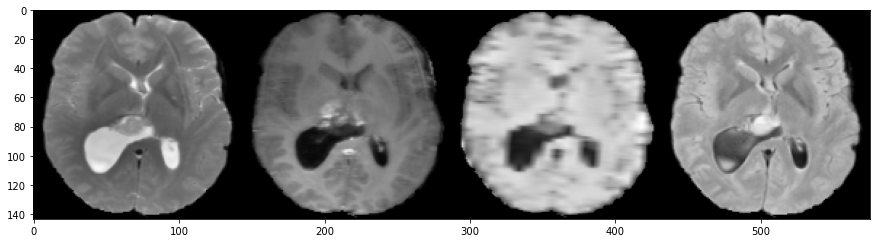

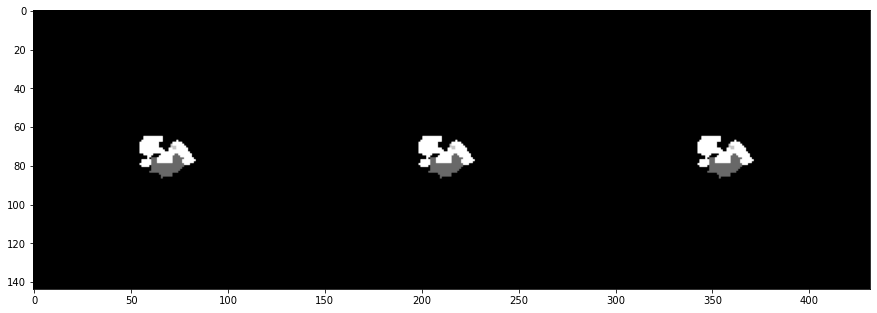

In [1218]:
# print scan ID
print(bratsID[0], '\nimage size:', p_image.shape, '\nseg size:', p_seg_image.shape)

# format MRI images (slices of volumetric input)
img = p_image[int(p_image.shape[0]/2), :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(15, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')
plt.show()

## plot segmentation mask ##
seg_img = p_seg_image[int(p_seg_image.shape[-1]/2), :, :].squeeze()
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(np.hstack([seg_img[0].T, seg_img[1].T, seg_img[2].T]), cmap='Greys_r')
plt.show()

In [777]:
import util

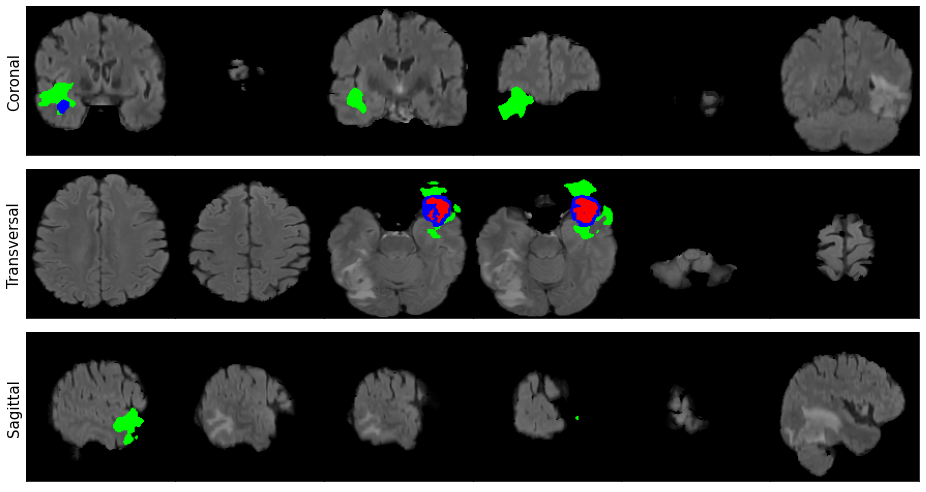

In [880]:
no_p_image = torch.permute(torch.squeeze(image), (1, 2, 3, 0)) # 144, 144, 144, 4 -> x, y, z, n
no_p_seg_image = torch.squeeze(seg_image) # 144, 144, 144 -> x, y, z

r_image = get_labeled_image(no_p_image.detach().cpu().numpy(), no_p_seg_image.detach().cpu().numpy())

util.plot_image_grid(r_image)

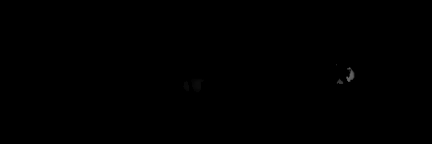

In [881]:
util.visualize_data_gif(r_image)

In [947]:
to_categorical(p_seg_image.squeeze()).shape

(144, 144, 144, 4)

In [948]:
np.unique(to_categorical(p_seg_image.squeeze()))

array([0., 1.], dtype=float32)

In [1211]:
# slice = int(p_image.shape[0]/2)
slice = 72

(4, 144, 144)
torch.Size([144, 144])
[0.0000000e+00 2.1832555e-07 4.3665111e-07 6.5497665e-07 8.7330221e-07
 1.0916277e-06 1.3099533e-06 9.9999958e-01 9.9999976e-01 1.0000000e+00
 1.0000002e+00 1.0000005e+00 1.0000006e+00 1.0000008e+00 1.9999992e+00
 1.9999994e+00 1.9999995e+00 1.9999998e+00 2.0000000e+00 2.0000002e+00
 2.0000005e+00 2.9999988e+00 2.9999990e+00 2.9999993e+00 2.9999995e+00
 2.9999998e+00 3.0000000e+00]


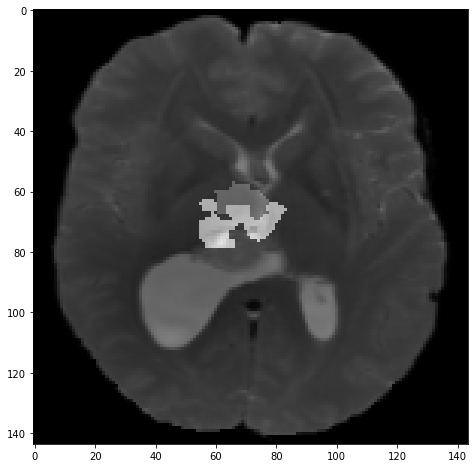

In [1222]:
#Overlay with Ground seg



img = p_image[slice, :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(10, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')


## plot segmentation mask ##
seg_img = p_seg_image[slice, :, :, :].squeeze()
print(seg_img.shape)
seg_img = torch.tensor(seg_img.numpy()[:, ::-1].copy()) #flip
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

print(np.unique(p_seg_image))
#seg_img = seg_img > 1
plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r', alpha=0.5)
plt.show()

In [31]:
y = [3] * 10
number = 90

In [32]:
ones = number % 10
tens = (number // 10) % 10
print(ones, tens)

0 9


In [33]:
y

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

(4, 144, 144)
[0. 1. 3.]


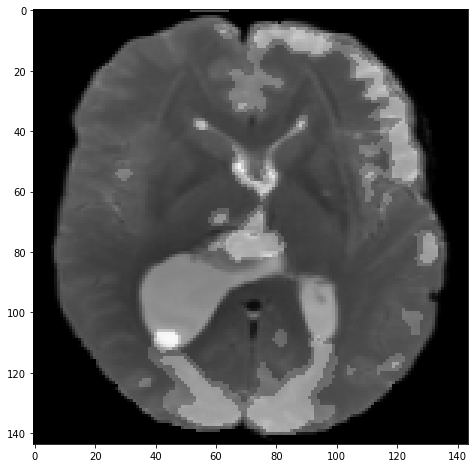

In [1223]:
#Overlay with Predicted
img = p_image[slice, :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(10, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')
## plot segmentation mask ##
seg_img = torch.tensor(labelmap[slice, :, :].squeeze())
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()
print(np.unique(seg_img))

#plt.figure(figsize=(4, 4))
plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r', alpha=0.3)
plt.show()

(4, 144, 144)


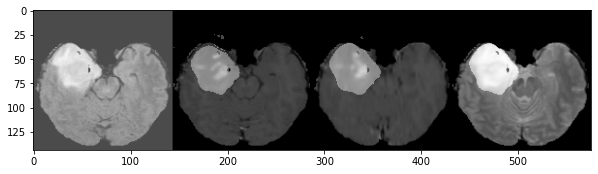

In [884]:
#Overlay with Predicted
img = p_image[slice, :, :, :].squeeze()
img = utils.make_grid(img)
img = img.detach().cpu().numpy()
print(img.shape)
# plot images
plt.figure(figsize=(10, 8))
img_list = [img[i].T for i in range(channels)] # 1 image per channel
plt.imshow(np.hstack(img_list), cmap='Greys_r')
## plot segmentation mask ##
seg_img = bool_mask[slice, :, :, :].squeeze()
seg_img = utils.make_grid(seg_img).detach().cpu().numpy()
#plt.figure(figsize=(4, 4))
plt.imshow(np.hstack([seg_img[0].T, seg_img[1].T, seg_img[2].T, seg_img[3].T]), cmap='Greys_r', alpha=0.3)
plt.show()

In [610]:
#bool_mask[int(bool_mask.shape[0]/2), :, :, :]

In [1166]:
np.unique(p_seg_image)
p_seg_image.squeeze().shape

torch.Size([144, 144, 144])

In [1207]:
ref_seg = p_seg_image.squeeze()
refmap_et, refmap_tc, refmap_wt = [np.zeros_like(ref_seg) for i in range(3)]
refmap_et = ref_seg == 3
refmap_tc = np.logical_or(refmap_et, ref_seg == 1)
refmap_wt = np.logical_or(refmap_tc, ref_seg == 2)
refmap = np.stack([refmap_et, refmap_tc, refmap_wt])

In [1208]:
refmap.shape

(3, 144, 144, 144)

In [1209]:
import pprint
HAUSSDORF = "haussdorf"
DICE = "dice"
SENS = "sens"
SPEC = "spec"
METRICS = [HAUSSDORF, DICE, SENS, SPEC]

In [1210]:
patient_metric_list = calculate_metrics(segs[1:], refmap, 'test')

{   'dice': 0.2830972134288228,
    'haussdorf': 112.8716084761797,
    'label': 'ET',
    'patient_id': 'test',
    'sens': 0.8822775727757277,
    'spec': 0.9713828413010471,
    'tta': False}
{   'dice': 0.2447989726365702,
    'haussdorf': 63.35613624582863,
    'label': 'TC',
    'patient_id': 'test',
    'sens': 0.8326948924731182,
    'spec': 0.9499635345630101,
    'tta': False}
{   'dice': 0.0004940711462450593,
    'haussdorf': 63.60031446463138,
    'label': 'WT',
    'patient_id': 'test',
    'sens': 0.00024830839903159724,
    'spec': 0.9999193234608397,
    'tta': False}


In [729]:
# bool_seg = p_seg_image > 0.18
seg_imgg = torch.tensor(p_seg_image.numpy()[:, :, :, ::-1].copy()) # turned to match orientation of predicted mask
bool_seg = seg_imgg > 0.18

In [1186]:
#preds, targets = bool_mask[:, 1, :, :], bool_seg.squeeze()
preds, targets = torch.tensor(segs[1:]), torch.tensor(refmap)

In [602]:
preds_coords = np.argwhere(preds) # we can only use 1,2,3 since 0 has no predicted seg mask
targets_coords = np.argwhere(targets)

In [748]:
haussdorf_dist = directed_hausdorff(preds_coords, targets_coords)[0]

ValueError: u and v need to have the same number of columns

In [1187]:
def dice_coefficient(y_true, y_pred, smooth=1.): # are the targets and pred in one hot encoding
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

In [1188]:
dice_coefficient(targets, preds)

tensor(0.0703)

In [746]:
tp = (l_and(torch.flatten(preds), torch.flatten(targets))).sum()
tn = (l_and(l_not(torch.flatten(preds)), l_not(torch.flatten(targets)))).sum()
fp = (l_and(torch.flatten(preds), l_not(torch.flatten(targets)))).sum()
fn = (l_and(l_not(torch.flatten(preds)), torch.flatten(targets))).sum()

sens = tp / (tp + fn)
spec = tn / (tn + fp)

dice = 2 * tp / (2 * tp + fp + fn)

In [747]:
print(f"Dice : {dice}, Spec : {spec}, Sens : {sens}")

Dice : 0.9105008244514465, Spec : 0.9951240420341492, Sens : 0.980120062828064


# Visual from Dataloader

torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
torch.Size([4, 144, 144, 144])
BraTS20_Training_052 
image size: torch.Size([8, 4, 144, 144, 144])


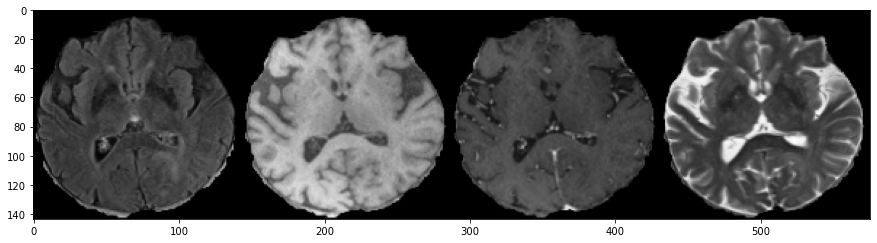

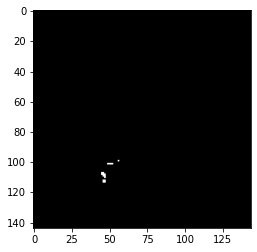

In [17]:
# visualize training (or validation) data
for i, data in enumerate(dataloader_train):
    # data batch
    (image, seg_image), bratsID = data
    # print scan ID
    print(bratsID[0], '\nimage size:', image.shape)
    
    # format MRI images (slices of volumetric input)
    img = image[0,:, :, :, int(image.shape[-1]/2)].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()
    
    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()

    ## plot segmentation mask ##
    seg_img = seg_image[0, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    plt.show()

    break

BraTS20_Training_237 
image size: torch.Size([4, 4, 144, 144, 144]) 
seg size: torch.Size([4, 1, 144, 144, 144])
72
torch.Size([4, 144, 144])
torch.Size([4, 144, 144])
(4, 144, 144)


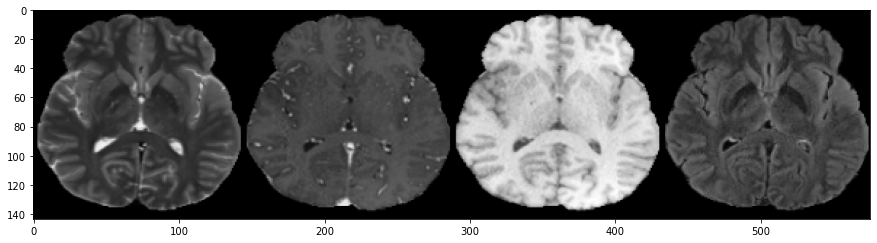

seg size: torch.Size([144, 144])
seg size 2: (3, 144, 144)
seg size 3: (144, 144)


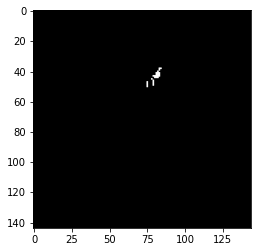

In [194]:
# visualize training (or validation) data
for i, data in enumerate(dataloader_train):
    # data batch
    (image, seg_image), bratsID = data
    # print scan ID
    print(bratsID[0], '\nimage size:', image.shape, '\nseg size:', seg_image.shape)
    
    # format MRI images (slices of volumetric input)
    print(f'{int(image.shape[-1]/2)}')
    img = image[1, :, :, :, int(image.shape[-1]/2)].squeeze()
    print(img.shape)
    img = utils.make_grid(img)
    print(img.shape)
    img = img.detach().cpu().numpy()
    print(img.shape)
    
    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()

    ## plot segmentation mask ##
    seg_img = seg_image[1, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    print(f"seg size: {seg_img.shape}")
    
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()
    print(f"seg size 2: {seg_img.shape}")
    
    plt.figure(figsize=(4, 4))
    
    print(f"seg size 3: {seg_img[0].shape}")
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    
    plt.show()

    break

In [ ]:
# Set random seed for reproduciablity
torch.manual_seed(577)
random.seed(577)

# The `init_features` defines how many channels the hidden layers contain.
# Usually, people would use 32 init features. Here, because our dataset
# is small, we use 4 init feautures. So, the channel size is about 32 / 4 = 8
# times smaller, and the training speed is about 8 x 8 = 64 times faster.


In [129]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=4, out_channels=1, init_features=4,
                        pretrained=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /Users/wisdomikezogwo/.cache/torch/hub/master.zip


In [1258]:
model = torch.load('second_100_mriseg.pt', map_location=torch.device('cpu'))
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_

In [1029]:
import torchvision.transforms.functional as F

from torchvision.utils import draw_segmentation_masks

plt.rcParams["savefig.bbox"] = 'tight'



In [1030]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [1259]:
# pred = model(p_image[:, 0, :, :].unsqueeze(1).float()) # only for 0(flair) modality model
with torch.no_grad():
    pred = model(p_image.float())

In [1257]:
pred.shape

torch.Size([144, 4, 144, 144])

In [1196]:
np.unique(pred.detach().cpu().numpy())

array([0.01115612, 0.01389843, 0.01397025, ..., 0.98704135, 0.9872896 ,
       0.9883477 ], dtype=float32)

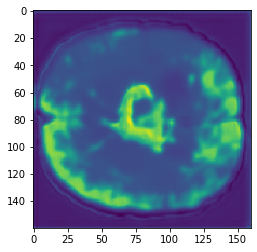

In [1244]:
plt.imshow(cv2.resize(pred[80, 3, :, :].detach().cpu().numpy(), (160, 160), interpolation = cv2.INTER_NEAREST))


In [1066]:
argspred = pred.argmax(dim=1)
#argspred = torch.permute(pred, (2, 3, 0, 1)).argmax(dim=-1)
#argspred = normalized_masks[:, 1:, :, :].argmax(dim=1)

print(np.unique(argspred.detach().cpu().numpy()))
argspred.shape

[0]


torch.Size([144, 144, 144])

In [1260]:
pred[0, :, 0, 8]

tensor([0.9526, 0.0932, 0.0505, 0.0461])

In [1198]:
pred_seg = torch.sigmoid(pred)

In [1246]:
pred_seg[0, :, 0, 8]

tensor([0.7216, 0.5233, 0.5126, 0.5115], grad_fn=<SelectBackward>)

In [1247]:
pred_seg.shape

torch.Size([144, 4, 144, 144])

In [1251]:
segs = pred_seg.permute(1, 0, 2, 3).detach().cpu().numpy() > 0.5   #4, 144, 144, 144 now i.e c, d, h, w,

In [1252]:
np.unique(segs)
#segs.shape 

array([ True])

In [1253]:
et = segs[1]
net = np.logical_and(segs[2], np.logical_not(et))
ed = np.logical_and(segs[3], np.logical_not(segs[2]))

labelmap = np.zeros(segs[1].shape)
labelmap[et] = 3
labelmap[net] = 1
labelmap[ed] = 2

In [1254]:
np.unique(labelmap)

array([3.])

[3.]


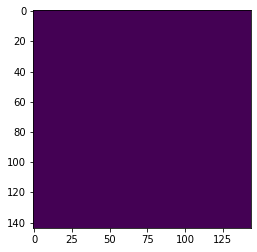

In [1255]:
sli = 70
plt.imshow(labelmap[sli])
print(np.unique(labelmap[sli]))

In [ ]:
pred = pred[0, :, :]  # remove the batch dimension
prob_max, pred = pred.max(dim=0)
pred = pred.swapaxes(0, 1)  # switch to (height, width)
pred = pred.detach().cpu().numpy()  # cast to numpy
pred = cv2.resize(pred, (w, h), interpolation = cv2.INTER_NEAREST)

In [905]:
print(np.unique(p_seg_image.detach().cpu().numpy()))
print(p_seg_image.shape)

ground_t = p_seg_image.argmax(dim=1)
print(np.unique(ground_t.detach().cpu().numpy()))
ground_t.shape

[0. 1. 2. 3.]
torch.Size([144, 1, 144, 144])
[857318]


torch.Size([])

In [1]:
normalized_masks = torch.nn.functional.softmax(pred, dim=1)

NameError: name 'torch' is not defined

In [1073]:
normalized_masks.max()

tensor(0.4600, grad_fn=<MaxBackward1>)

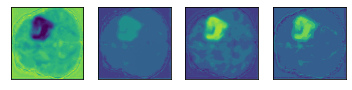

In [1074]:
show([m.float() for m in normalized_masks[72]])

In [1075]:
torch.tensor(math.ceil((normalized_masks.min().item()*100))/100)

tensor(0.1800)

In [1013]:
bool_mask = normalized_masks == .3

In [1014]:
np.unique(bool_mask)

array([False])

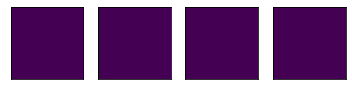

In [1015]:
show([m.float() for m in bool_mask[72]])

In [320]:
h = normalized_masks.argmax(3)

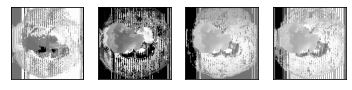

In [322]:
show([m.float() for m in ])

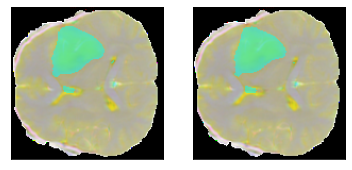

In [514]:

mri_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.5, colors="red").to(torch.float)
    for img, mask in zip((p_image[78:80, 1:, :, :] * 255).to(torch.uint8), bool_mask[78:80, 1:, :, :])
]
show(mri_with_masks)


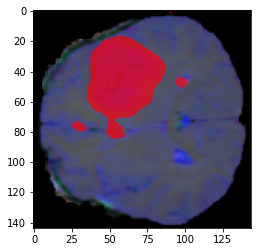

In [507]:
plt.imshow(draw_segmentation_masks((p_image[72, 1:, :, :] * 255).to(torch.uint8), masks=bool_mask[72, 2, :, :], alpha=0.7, colors="red").permute(1, 2, 0))


In [261]:
# pred = pred[2, :, :, :].detach().cpu().numpy()  # cast to numpy  # remove the batch dimension
#prob_max, pred = pred.max(dim=0)

In [224]:
# pred.shape
#pred = pred.swapaxes(0, 1)  # switch to (height, width)
#pred = pred.detach().cpu().numpy()  # cast to numpy

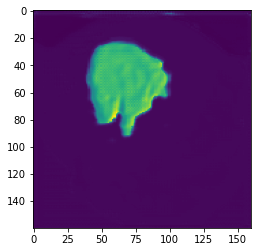

In [265]:

plt.imshow(cv2.resize(pred[60, :, :, :].detach().cpu().numpy()[3, :, :], (160, 160), interpolation = cv2.INTER_NEAREST))


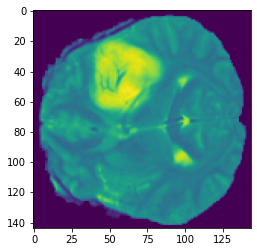

In [444]:
plt.imshow(p_image[72, 3, :, :])

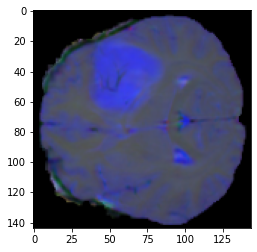

In [515]:
plt.imshow((p_image[72, 1:, :, :] * 255).to(torch.uint8).permute(1, 2, 0))

In [519]:
(p_image[72, 1:, :, :] * 255).to(torch.uint8)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [4]:
torch.randn(dim_out, dim_in, generator=None)

tensor([-0.4929])

In [18]:
a = torch.tensor([[-0.3711, -0.3711, -0.3711, -0.2917],
                  [ 0.1815, -1.0111,  0.1815, -1.5923],
                  [ 0.1062,  1.4581,  0.1062, -1.2344]])

b = torch.tensor([ 0.8032,  0.5032, 0.8032])

torch.div(a.T, b).T

tensor([[-0.4620, -0.4620, -0.4620, -0.3632],
        [ 0.3607, -2.0093,  0.3607, -3.1643],
        [ 0.1322,  1.8154,  0.1322, -1.5369]])

In [12]:
aa = a = torch.tensor([[-0.3711, -0.3711, -0.3711, -0.2917],
                  [ 0.1815, -1.0111,  0.1815, -1.5923],
                  [ 0.1062,  1.4581,  0.1062, -1.2344]])


In [14]:
torch.sum(aa, dim=1)

tensor([-1.4050, -2.2404,  0.4361])

In [19]:
            x = torch.tensor(
                [
                    [0.3432, 0.4780, 0.1788],
                    [0.4121, 0.0274, 0.5604],
                    [0.2109, 0.5084, 0.2807],
                    [0.7671, 0.9303, -0.6973],
                    [0.1812, 0.2905, 0.5283],
                ]
            )
            target = torch.tensor([0, 1, 2, 1, 2]).long()

In [75]:

su = torch.tensor(0.0)
for i in range(len(x)):
    su += torch.log(x[i][target[i]])
print(su, su/len(x))

tensor(-6.6475) tensor(-1.3295)


In [77]:
x[target[0]]

tensor([0.3432, 0.4780, 0.1788])

In [76]:
target[0]

tensor(0)

In [6]:
torch.eye(3)[torch.tensor([0, 1, 2, 1, 2]).long()].long()

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1]])

In [10]:
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
non_zero_idx = np.nonzero(x)
non_zero_idx

(array([0, 1, 2, 2]), array([0, 1, 0, 1]))

In [8]:
min_idx = [np.min(idx) for idx in non_zero_idx]
# +1 because slicing is like range: not inclusive!!
max_idx = [np.max(idx) + 1 for idx in non_zero_idx]
bbox = tuple(slice(_min, _max) for _min, _max in zip(min_idx, max_idx))



In [16]:
len(set(tuple(x.shape)))

1

In [20]:
for d in x.shape:
    print(d)

3
3


In [59]:
u.T @ torch.log(x).long()

tensor([[                  -1,                    0,                   -1],
        [                   0,                   -3, -9223372036854775808],
        [                  -2,                   -1,                   -1]])

In [47]:
torch.log(x)

tensor([[-1.0694, -0.7381, -1.7215],
        [-0.8865, -3.5972, -0.5791],
        [-1.5564, -0.6765, -1.2705],
        [-0.2651, -0.0722,     nan],
        [-1.7082, -1.2362, -0.6381]])

In [57]:
np.dot(u.T, torch.log(x))

array([[-1.06944191, -0.73814458,         nan],
       [-1.15162742, -3.66946048,         nan],
       [-3.26452506, -1.91263837,         nan]])

In [51]:
import numpy as np

In [60]:
torch.sum(u * x, dim=-1)

tensor([0.3432, 0.0274, 0.2807, 0.9303, 0.5283])

In [74]:
u.shape

torch.Size([5, 3])

In [79]:
from torch.distributions import Uniform
import math

In [80]:
d = 70
h = 10

In [85]:
w = Uniform(-1/math.sqrt(d), 1/math.sqrt(d)).rsample(sample_shape=(h,))

In [86]:
w.shape

torch.Size([10])

In [87]:
a = torch.randn(3, 4)
a
torch.max(a, 1)

torch.return_types.max(
values=tensor([1.4334, 0.7133, 2.7742]),
indices=tensor([0, 2, 3]))

In [88]:
a

tensor([[ 1.4334, -0.0118,  0.5560, -1.6664],
        [-0.4087, -0.0256,  0.7133, -1.1873],
        [-0.3311, -1.5660,  0.3794,  2.7742]])

In [89]:
max_prob, pred = torch.max(a, 1)

In [113]:
b = torch.tensor([0, 2, 3])

In [114]:
torch.equal(pred, b)

True

In [115]:
torch.mean((pred == b).float())

tensor(1.)

In [ ]:
to_one_hot

In [71]:
pred = torch.tensor([[0.4959, 0.5041],
        [0.4970, 0.5030],
        [0.4970, 0.5030],
        [0.4969, 0.5031],
        [0.4957, 0.5043],
        [0.4968, 0.5032],
        [0.4978, 0.5022],
        [0.4966, 0.5034]]) 
label = torch.tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]], dtype=torch.float64)

In [2]:
label

NameError: name 'label' is not defined

In [72]:
max_prob, pd = torch.max(pred, 1)
to_one_hot(pd)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [83]:
to_one_hot(pd).T.dot(label.numpy())

array([[0., 0.],
       [7., 1.]])

In [108]:
torch.mean(torch.tensor([torch.equal(torch.tensor(to_one_hot(pd)[7]), label[7])]).float())

tensor(1.)

In [110]:
np.argmax(pred, 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1])

In [111]:
np.argmax(label, 1)

tensor([0, 0, 0, 0, 0, 0, 0, 1])

In [112]:
np.average(np.equal(np.argmax(pred, 1), np.argmax(label, 1)))

0.125

In [116]:
torch.mean((np.argmax(pred, 1) == np.argmax(label, 1)).float()).item()

0.125

In [105]:
correct = 0
for i in range(len(label)):
    if torch.equal(torch.tensor(to_one_hot(pd)[i]), label[i]):
        correct += 1
        
correct/len(label)

0.125

In [92]:
sum((pred == label).tolist())

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [100]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Uniform
from torch.nn import Module
from torch.nn.functional import cross_entropy, relu
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [106]:
class F1(Module):
    def __init__(self, h: int, d: int, k: int):
        """Create a F1 model as described in pdf.

        Args:
            h (int): Hidden dimension.
            d (int): Input dimension/number of features.
            k (int): Output dimension/number of classes.
        """
        super().__init__()
        self.w0 = Parameter(Uniform(-1/math.sqrt(d), 1/math.sqrt(d)).rsample(sample_shape=(d, h)))
        self.b0 = Parameter(Uniform(-1/math.sqrt(d), 1/math.sqrt(d)).rsample(sample_shape=(h,)))

        self.w1 = Parameter(Uniform(-1 / math.sqrt(h), 1 / math.sqrt(h)).rsample(sample_shape=(h, k)))
        self.b1 = Parameter(Uniform(-1 / math.sqrt(h), 1 / math.sqrt(h)).rsample(sample_shape=(k,)))
    
    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.w0, self.b0, self.w1, self.b1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Pass input through F1 model.

        It should perform operation:
        W_1(sigma(W_0*x + b_0)) + b_1

        Args:
            x (torch.Tensor): FloatTensor of shape (n, d). Input data.

        Returns:
            torch.Tensor: LongTensor of shape (n, k). Prediction.
        """
        a0 = relu(x @ self.w0 + self.b0)
        out = a0 @ self.w1 + self.b1
        return out



In [107]:
f1 = F1(64, 784, 10)

In [109]:
pytorch_total_params = sum(p.numel() for p in f1.parameters() if p.requires_grad)


In [110]:
pytorch_total_params

50890

In [ ]:
w0_num + b0_num : (784 * 64) + 64 = 50240
w0_num + b0_num : 64 * 10 + 10 = 650
    
total = 50890

In [118]:
(784 * 32) + 32 + (32 * 32) + 32 + (32 * 10) +10

26506

In [121]:
1e-2

0.01

In [120]:
5e-2

0.05

In [122]:
! pip install networkx[default]

zsh:1: no matches found: networkx[default]


In [123]:
names = ["Isaac Newton", "Albert Einstein", "Niels Bohr", "Marie Curie", "Charles Darwin",
         "Louis Pasteur", "Galileo Galilei", "Margaret Mead"]

In [124]:
print("sorted(names):", sorted(names))


sorted(names): ['Albert Einstein', 'Charles Darwin', 'Galileo Galilei', 'Isaac Newton', 'Louis Pasteur', 'Margaret Mead', 'Marie Curie', 'Niels Bohr']


In [125]:
def mystery(msg):
    return msg.split(" ")[1]
x = mystery("happy birthday")
print(x)

birthday


In [126]:
fruits = ["watermelon", "fig", "apple"]
print(sorted(fruits))
print(sorted(fruits, key=len))

['apple', 'fig', 'watermelon']
['fig', 'apple', 'watermelon']


In [127]:
import operator
lst1 = [2, 7, 3, 9, 4]
print(operator.itemgetter(1)(lst1))
print(operator.itemgetter(1, 2)(lst1))
print(operator.itemgetter(2, 3)(lst1))
tup2 = operator.itemgetter(3, 2, 1, 0)(lst1)
print(tup2)
print(operator.itemgetter(0)(tup2))
get_second = operator.itemgetter(1)
print(get_second(tup2))
print(operator.itemgetter(2)("howdy"))
print(operator.itemgetter(2, 0, 1)("howdy"))

7
(7, 3)
(3, 9)
(9, 3, 7, 2)
9
3
w
('w', 'h', 'o')
